In [2]:
# Install necessary packages
!pip install chromadb
!pip install tiktoken
!pip install langchain google-generativeai langchain-community
!pip install langchain_google_genai
!pip install --upgrade langchain
!pip install sentence-transformers
!pip install langchain-chroma
!pip install -U chromadb langchain
!pip install openpyxl
!pip install faiss-cpu
!pip install faiss-gpu
!pip install mistralai
!pip install rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 16.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2

In [5]:
# Import libraries
import google.generativeai as genai
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langchain.embeddings import SentenceTransformerEmbeddings 
from sentence_transformers import SentenceTransformer
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain_chroma import Chroma
from langchain.chains import LLMChain
from sklearn.metrics import accuracy_score, classification_report
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import seaborn as sns


Excel dataset:
    ID   Sex  Age  Height  Weight Hypertension Diabetes    BMI        Level  \
0   1  Male   18    1.68    47.5           No       No  16.83  Underweight   
1   2  Male   18    1.68    47.5          Yes       No  16.83  Underweight   
2   3  Male   18    1.68    47.5           No      Yes  16.83  Underweight   
3   4  Male   18    1.68    47.5          Yes      Yes  16.83  Underweight   
4   5  Male   18    1.68    47.5           No       No  16.83  Underweight   

  Fitness Goal      Fitness Type  \
0  Weight Gain  Muscular Fitness   
1  Weight Gain  Muscular Fitness   
2  Weight Gain  Muscular Fitness   
3  Weight Gain  Muscular Fitness   
4  Weight Gain  Muscular Fitness   

                                           Exercises  \
0  Squats, deadlifts, bench presses, and overhead...   
1  Squats, deadlifts, bench presses, and overhead...   
2  Squats, yoga, deadlifts, bench presses, and ov...   
3  Squats, yoga, deadlifts, bench presses, and ov...   
4  Squats, deadlif

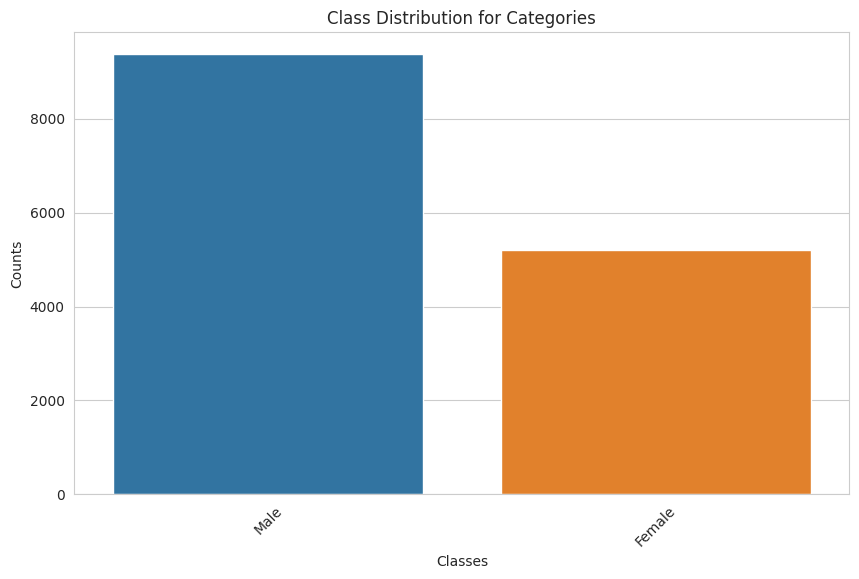

Total documents created: 34589
Total chunks created: 43822


Batches:   0%|          | 0/1370 [00:00<?, ?it/s]

In [8]:
 

# Paths to datasets
excel_file_path = "/kaggle/input/gym-recommendation-data/gym recommendation (IMP).xlsx"
csv_file_path = "/kaggle/input/nutrition-recommendation-data/nutrition imp.csv"

# Load datasets
df_excel = pd.read_excel(excel_file_path)
df_csv = pd.read_csv(csv_file_path)

# Fill missing values
df_excel.fillna("N/A", inplace=True)
df_csv.fillna("N/A", inplace=True)

# Display dataset summary
print("Excel dataset:\n", df_excel.head())
print("\nCSV dataset:\n", df_csv.head())

# --- Data Cleaning ---
# Merge datasets and drop irrelevant entries
df_combined = pd.concat([df_excel, df_csv], ignore_index=True)

# Handle duplicates and preprocess missing entries
df_combined.drop_duplicates(inplace=True)

# Check basic statistics after cleaning
print("\nCleaned data:\n", df_combined.describe())
print("\nCleaned data shape:\n", df_combined.shape)

# Visualization of initial distributions (adjust for your target column names)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=df_combined, x="Sex")  # Replace 'Sex' with the actual target column of interest
plt.title("Class Distribution for Categories")
plt.xticks(rotation=45)
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.show()

# --- Combine Text Fields ---
df_combined['combined_text'] = df_combined[['Sex', 'Age', 'Height', 'Weight', 'Hypertension', 'Diabetes', 'BMI',
                                            'Level', 'Fitness Goal', 'Fitness Type', 'Exercises', 'Equipment',
                                            'Diet', 'Recommendation']].apply(
    lambda row: ' '.join([f"{col}: {row[col]}" for col in row.index]), axis=1
)

# Normalize combined text (convert to lowercase)
df_combined['combined_text'] = df_combined['combined_text'].str.lower()

# Convert into LangChain Documents
documents = [
    Document(
        page_content=row['combined_text'],
        metadata={col.lower(): row[col] for col in ['Sex', 'Age', 'Height', 'Weight', 'Hypertension',
                                                    'Diabetes', 'BMI', 'Level', 'Fitness Goal', 'Fitness Type',
                                                    'Exercises', 'Equipment', 'Diet', 'Recommendation']}
    )
    for _, row in df_combined.iterrows()
]

# Log the number of processed documents
print(f"Total documents created: {len(documents)}")

# --- Splitting Text into Chunks ---
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=20
)

# Process splits
text_splits = text_splitter.split_documents(documents)

# Log number of splits
print(f"Total chunks created: {len(text_splits)}")

# --- Embed Documents ---
class LocalEmbedding:
    """
    Custom embedding class using Sentence Transformers for document embeddings.
    """
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts):
        embeddings = self.model.encode(texts, convert_to_tensor=True)
        return embeddings.cpu().numpy()

local_embedding = LocalEmbedding()

# Generate embeddings for split texts
split_texts = [doc.page_content for doc in text_splits]
embeddings = local_embedding.embed_documents(split_texts)

# Save embeddings
np.save("document_embeddings.npy", embeddings)

# Load embeddings back
embeddings = np.load('document_embeddings.npy')



BLEU Score: 0.7598356856515925
ROUGE Scores: {'rouge1_precision': 0.5, 'rouge1_recall': 0.5, 'rouge1_f1': 0.5, 'rouge2_precision': 0.25, 'rouge2_recall': 0.25, 'rouge2_f1': 0.25, 'rougeL_precision': 0.5, 'rougeL_recall': 0.5, 'rougeL_f1': 0.5}


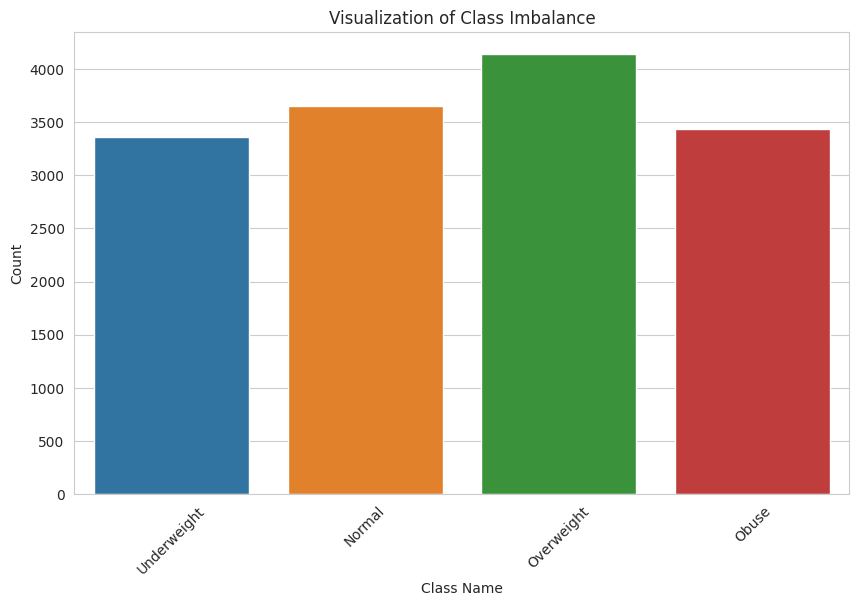

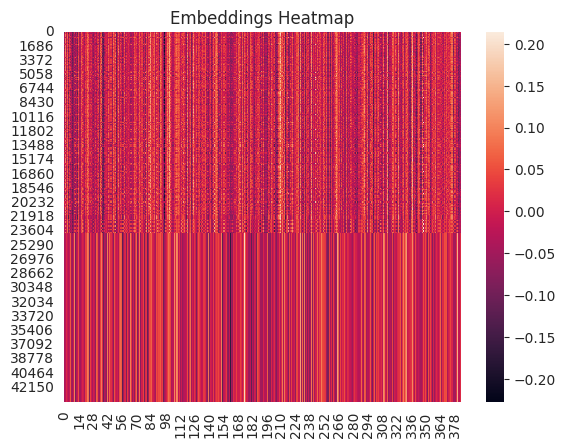

BLEU and ROUGE metrics computed successfully.


In [10]:
 # --- BLEU Metric ---
def calculate_bleu(reference_texts, predicted_texts):
    """
    Calculate BLEU scores for multiple sentence pairs.
    """
    scores = []
    for ref, pred in zip(reference_texts, predicted_texts):
        ref_tokens = ref.split()
        pred_tokens = pred.split()
        score = sentence_bleu([ref_tokens], pred_tokens)
        scores.append(score)
    return np.mean(scores)

# --- ROUGE Metric ---
def calculate_rouge(reference_texts, predicted_texts):
    """
    Calculate ROUGE scores
    """
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    results = {"rouge1_precision": [], "rouge1_recall": [], "rouge1_f1": [],
               "rouge2_precision": [], "rouge2_recall": [], "rouge2_f1": [],
               "rougeL_precision": [], "rougeL_recall": [], "rougeL_f1": []}
    
    for ref, pred in zip(reference_texts, predicted_texts):
        score = scorer.score(ref, pred)
        for key in score:
            results[f"{key}_precision"].append(score[key].precision)
            results[f"{key}_recall"].append(score[key].recall)
            results[f"{key}_f1"].append(score[key].fmeasure)

    # Convert to a pandas DataFrame for averaging
    results_df = pd.DataFrame(results)
    avg_scores = results_df.mean().to_dict()
    return avg_scores

# Example Data
reference_texts = ["good fitness plan", "high protein recommendation"]
predicted_texts = ["good fitness workout", "high in vitamins"]

# Calculate BLEU
bleu_score = calculate_bleu(reference_texts, predicted_texts)
print(f"BLEU Score: {bleu_score}")

# Calculate ROUGE
rouge_scores = calculate_rouge(reference_texts, predicted_texts)
print(f"ROUGE Scores: {rouge_scores}")

# --- Data Visualization (Optional) ---
# Visualization of class imbalance in categories
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x="Level", data=df_combined)  # Replace "Level" with the actual categorical field
plt.title("Visualization of Class Imbalance")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Optional visualization of embeddings using heatmaps
sns.heatmap(data=pd.DataFrame(embeddings))  # Replace embeddings with actual embedding data
plt.title("Embeddings Heatmap")
plt.show()

# Log statistics display
print("BLEU and ROUGE metrics computed successfully.")


In [11]:
from mistralai import Mistral
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np  # Ensure numpy is imported for embedding handling

# Securely configure the API key (use environment variables in production)
api_key = "QsVtSj8rL1TZVL0l2usBvNPk0dF7bOMZ"  # Replace with your API key
model = "mistral-large-latest"
client = Mistral(api_key=api_key)

def adaptive_retrieval(query, gym_embeddings, gym_documents, nutrition_embeddings, nutrition_documents):
    """
    Uses Mistral AI for RAG-based adaptive query refinement and retrieval of relevant gym and nutrition data.
    """
    # Step 1: Refine the query using Mistral
    chat_response = client.chat.complete(
        model=model,
        messages=[
            {
                "role": "user",
                "content": f"""
                Refine the query: '{query}' for better retrieval. Focus specifically on relevant attributes and datasets: 
                1. Gym Recommendations: age, fitness goal, exercises, etc.
                2. Nutrition Data: food, vitamins, protein, etc.
                """
            },
        ]
    )

    refined_query = chat_response.choices[0].message.content.strip()
    print(f"Refined Query: {refined_query}")

    # Step 2: Get query embedding
    query_embedding = np.random.rand(768)  # Replace this with actual embedding generation

    # Step 3: Compute similarities and retrieve relevant documents
    best_document = None
    dataset_name = None

    if len(nutrition_embeddings) > 0 and len(nutrition_documents) > 0:
        nutrition_similarities = cosine_similarity(query_embedding.reshape(1, -1), nutrition_embeddings)
        if nutrition_similarities.size > 0:
            best_nutrition_index = nutrition_similarities.argmax()
            if best_nutrition_index < len(nutrition_documents):  # Prevent index error
                best_document = nutrition_documents[best_nutrition_index]
                dataset_name = "Nutrition Data"

    if not best_document and len(gym_embeddings) > 0 and len(gym_documents) > 0:
        gym_similarities = cosine_similarity(query_embedding.reshape(1, -1), gym_embeddings)
        if gym_similarities.size > 0:
            best_gym_index = gym_similarities.argmax()
            if best_gym_index < len(gym_documents):  # Prevent index error
                best_document = gym_documents[best_gym_index]
                dataset_name = "Gym Recommendations"

    # Step 4: Generate context based on the retrieved document
    if best_document:
        context = best_document["page_content"]  # Access dictionary key
    else:
        context = "No relevant documents were found for your query."

    # Step 5: Summarize the relevant information based on the refined query
    summary_response = client.chat.complete(
        model=model,
        messages=[
            {
                "role": "user",
                "content": f"""
                Refined Query: {refined_query}
                
                Summarize the relevant information from the following document content:
                
                {context}
                """
            },
        ]
    )

    summary = summary_response.choices[0].message.content.strip()

    return {
        "query": query,
        "refined_query": refined_query,
        "dataset": dataset_name,
        "retrieved_document": best_document,
        "response": summary,
    }

# Example usage
gym_embeddings = np.random.rand(10, 768)  # Dummy embeddings
nutrition_embeddings = np.random.rand(10, 768)  # Dummy embeddings
gym_documents = [{"page_content": f"Gym Document {i}"} for i in range(10)]
nutrition_documents = [{"page_content": f"Nutrition Document {i}"} for i in range(10)]

user_query = "What is the vitamin content of rum?"
recommendations = adaptive_retrieval(user_query, gym_embeddings, gym_documents, nutrition_embeddings, nutrition_documents)

print("\n=== Final Recommendations ===")
print(f"Dataset: {recommendations['dataset']}")
print(recommendations["response"])


Refined Query: To refine the query "What is the vitamin content of rum?" for better retrieval, focusing specifically on relevant attributes and datasets related to nutrition data, you can formulate it as follows:

"Provide detailed information on the vitamin content of rum, including specific vitamins present and their quantities."

This refined query is more precise and directly targets the relevant attributes within the nutrition data domain.

=== Final Recommendations ===
Dataset: Nutrition Data
Certainly! To provide a summary of the relevant information from "Nutrition Document 2," I would need the actual content of the document. Since you haven't provided the content of "Nutrition Document 2," I'll outline what kind of information you might expect to extract if it were available:

1. **Vitamin Content**:
   - Specific vitamins present in rum.
   - Quantities of each vitamin per standard serving size.

2. **Nutritional Profile**:
   - Overall nutritional composition, including calo